In [1]:
import numpy as np
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from scipy import linalg as la

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

with open("input_phrases.txt", "r") as f:
    phrases = [line.strip() for line in f.readlines() if line.strip()]

cosine_sim_stat = []
for current_text in phrases:

    # Input text
    text = current_text
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs.input_ids

    # Forward pass with hidden states
    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True, return_dict=True)

    hidden_states = outputs.hidden_states  # Tuple: [embedding] + [each layer output]
    lm_head = model.lm_head               # Final linear layer (tied to embeddings)

    last_vectors = np.array([layer[:, -1, :].squeeze(0).numpy() for layer in hidden_states])

    final_vector = last_vectors[-1]  # Shape: [hidden_size]

    projection_history = np.zeros(last_vectors.shape[0])
    norm_final = la.norm(final_vector)

    for i in range(last_vectors.shape[0]):
        # Cosine similarity == projection onto unit direction
        norm_current = la.norm(last_vectors[i,:])
        
        cosine_sim = np.dot(last_vectors[i,:]/norm_current, final_vector/norm_final)
        projection_history[i] = cosine_sim
    
    cosine_sim_stat.append(projection_history)



/home/william/anaconda3/envs/python3_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-05-14 14:36:50.072750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 14:36:50.721265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cosine_sim_stat = np.array(cosine_sim_stat)
cosine_sim_stat_avg = np.mean(cosine_sim_stat, axis = 0)
cosine_sim_stat_std = np.std(cosine_sim_stat,axis = 0)

cosine_sim_stat_avg.shape
cosine_sim_stat.shape

(160, 13)

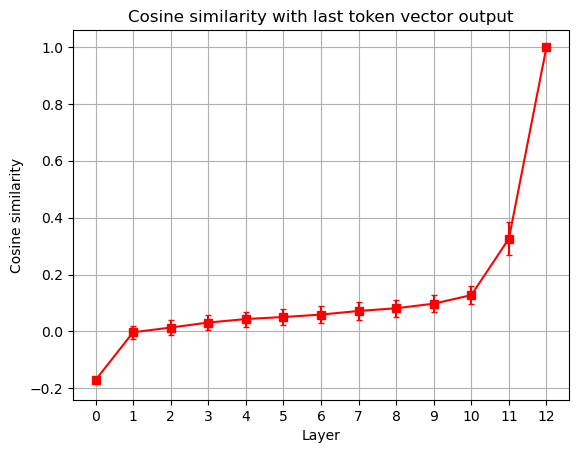

In [3]:
plt.errorbar(np.arange(0,13,1), cosine_sim_stat_avg, linestyle = '-' ,marker = 's', yerr = cosine_sim_stat_std, capsize = 2, color = 'red')
plt.title("Cosine similarity with last token vector output")
plt.xlabel("Layer")
plt.xticks(np.arange(0,13,1))
plt.ylabel("Cosine similarity")
plt.grid()

In [26]:
import torch
import torch.nn.functional as F
from transformers import GPT2Model, GPT2Tokenizer
import types

# Load model and tokenizer
model = GPT2Model.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model.eval()

ln1_outputs_global = []
ln2_outputs_global = []
mlp_proj_outputs_global = []
residual_outputs_global = []

with open("input_phrases.txt", "r") as f:
    phrases = [line.strip() for line in f.readlines() if line.strip()]

    
    for current_text in phrases:
        # Input text
        text = current_text
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs.input_ids
        
        # Buffers for extracted info
        per_head_outputs = []
        ln1_outputs = []
        ln2_outputs = []
        mlp_fc_outputs = []
        mlp_act_outputs = []
        mlp_proj_outputs = []
        residual_outputs = []

        # Custom GPT2Attention forward with proper return handling
        def custom_attention_forward(self, hidden_states, layer_past=None, attention_mask=None,
                                    head_mask=None, use_cache=False, output_attentions=False):
            query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)

            batch_size, seq_len, _ = hidden_states.size()
            num_heads = self.num_heads
            head_dim = self.head_dim
            scale = 1.0 / (head_dim ** 0.5)

            def split_heads(x):
                return x.view(batch_size, seq_len, num_heads, head_dim).permute(0, 2, 1, 3)

            def merge_heads(x):
                return x.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, num_heads * head_dim)

            query = split_heads(query)
            key = split_heads(key)
            value = split_heads(value)

            # Causal mask
            attn_scores = torch.matmul(query, key.transpose(-1, -2)) * scale
            causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=attn_scores.device)).unsqueeze(0).unsqueeze(0)
            attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))
            attn_weights = F.softmax(attn_scores, dim=-1)
            attn_output = torch.matmul(attn_weights, value)

            # Store per-head output
            per_head_outputs.append(attn_output.detach().clone())

            attn_output = merge_heads(attn_output)
            attn_output = self.c_proj(attn_output)
            attn_output = self.resid_dropout(attn_output)

            present = (key, value) if use_cache else None
            outputs = (attn_output, present)
            if output_attentions:
                outputs += (attn_weights,)

            return outputs

        # Hook functions
        def get_ln1_output(module, input, output):
            ln1_outputs.append(output.detach().clone())

        def get_ln2_output(module, input, output):
            ln2_outputs.append(output.detach().clone())

        def get_mlp_fc_output(module, input, output):
            mlp_fc_outputs.append(output.detach().clone())

        def get_mlp_act_output(module, input, output):
            mlp_act_outputs.append(output.detach().clone())

        def get_mlp_proj_output(module, input, output):
            mlp_proj_outputs.append(output.detach().clone())

        def get_residual_output(module, input, output):
            residual_outputs.append(output.detach().clone())

        # Register hooks
        hooks = []
        for block in model.h:
            hooks.append(block.ln_1.register_forward_hook(get_ln1_output))
            hooks.append(block.ln_2.register_forward_hook(get_ln2_output))
            hooks.append(block.mlp.c_fc.register_forward_hook(get_mlp_fc_output))
            hooks.append(block.mlp.act.register_forward_hook(get_mlp_act_output))
            hooks.append(block.mlp.c_proj.register_forward_hook(get_mlp_proj_output))
            hooks.append(block.attn.resid_dropout.register_forward_hook(get_residual_output))
            block.attn.forward = types.MethodType(custom_attention_forward, block.attn)

        # Run model
        with torch.no_grad():
            _ = model(**inputs, return_dict=False)

        # Remove hooks
        for h in hooks:
            h.remove()

        # Get last-token vectors
        last_fc = [x[0, -1, :].clone() for x in mlp_fc_outputs]
        last_act = [x[0, -1, :].clone() for x in mlp_act_outputs]
        last_proj = [x[0, -1, :].clone() for x in mlp_proj_outputs]

    

        
        # Summary printouts
        print("\n=== Attention Head Outputs ===")
        for i, heads in enumerate(per_head_outputs):
            print(f"Layer {i}: {heads.shape}  # [1, num_heads, seq_len, head_dim]")

        print("\n=== LayerNorm Outputs ===")
        for i, (ln1, ln2) in enumerate(zip(ln1_outputs, ln2_outputs)):
            print(f"Layer {i}: ln_1 -> {ln1.shape}, ln_2 -> {ln2.shape}")
            ln1_outputs_global.append(ln1[0, -1, :])
            ln2_outputs_global.append(ln2[0, -1, :])
            

        mlp_proj_outputs_global.append(last_proj)
        print("\n=== MLP Outputs ===")
        for i in range(len(mlp_fc_outputs)):
            print(f"Layer {i}: c_fc -> {mlp_fc_outputs[i].shape}, act -> {mlp_act_outputs[i].shape}, c_proj -> {mlp_proj_outputs[i].shape}")
            

        print("\n=== Last Token Vectors from MLP ===")
        for i in range(len(last_fc)):
            print(f"Layer {i}: last_fc -> {last_fc[i].shape}, last_act -> {last_act[i].shape}, last_proj -> {last_proj[i].shape}")
            
        

        print("\n=== Residual Outputs ===")
        for i, residual in enumerate(residual_outputs):
            print(f"Layer {i}: Residual output shape -> {residual.shape}")
            residual_outputs_global.append(residual[0,-1,:])
    
   



=== Attention Head Outputs ===
Layer 0: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 1: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 2: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 3: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 4: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 5: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 6: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 7: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 8: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 9: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 10: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]
Layer 11: torch.Size([1, 12, 12, 64])  # [1, num_heads, seq_len, head_dim]

=== LayerNorm Outputs ===
Layer 0: ln_1 -> torch.Size([1, 12, 768]), ln_2 -> 

In [45]:
ln1_outputs_global = np.array(ln1_outputs_global).reshape((160,12,768))
ln2_outputs_global = np.array(ln2_outputs_global).reshape((160,12,768))
mlp_proj_outputs_global = np.array(mlp_proj_outputs_global).reshape((160,12,768))
attention_outputs_global = np.array(residual_outputs_global).reshape((160,12,768))



In [46]:
def avg_cos_sim(histories, final_vector):
    final_vector_norm = final_vector / la.norm(final_vector)
    cosine_sim_total = np.array([
        [np.dot(histories[i, j, :] / la.norm(histories[i, j, :]), final_vector_norm)
         for j in range(histories.shape[1])]
        for i in range(histories.shape[0])
    ])  # shape: (160, 12)
    return cosine_sim_total.mean(axis=0), cosine_sim_total.std(axis=0)  


In [47]:
cos_sim_ln1 = avg_cos_sim(ln1_outputs_global,final_vector)
cos_sim_ln2 = avg_cos_sim(ln2_outputs_global,final_vector)
cos_sim_mlp_proj = avg_cos_sim(mlp_proj_outputs_global,final_vector)
cos_sim_attention = avg_cos_sim(attention_outputs_global,final_vector)

In [48]:
def plot_avg_cos_sim(meanvalues,std,col,title,marker):
    plt.errorbar(np.arange(1,13,1), meanvalues, linestyle = '-' , marker = marker, yerr = std, capsize = 2, color = col)
    plt.title(title)
    plt.xlabel("Layer")
    plt.xticks(np.arange(1,13,1))
    plt.ylabel("Cosine similarity")
    plt.grid()

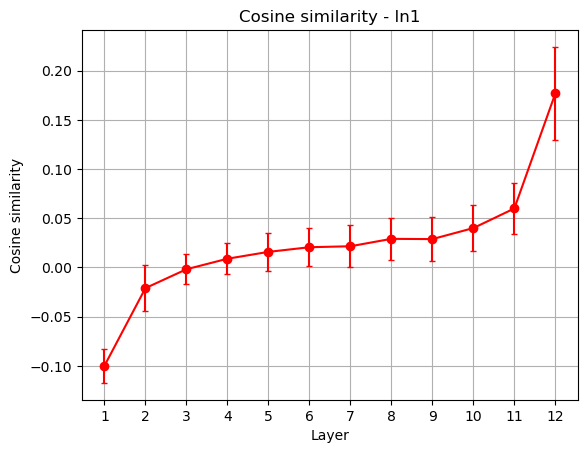

In [49]:
plot_avg_cos_sim(cos_sim_ln1[0],cos_sim_ln1[1],'red','Cosine similarity - ln1', 'o')

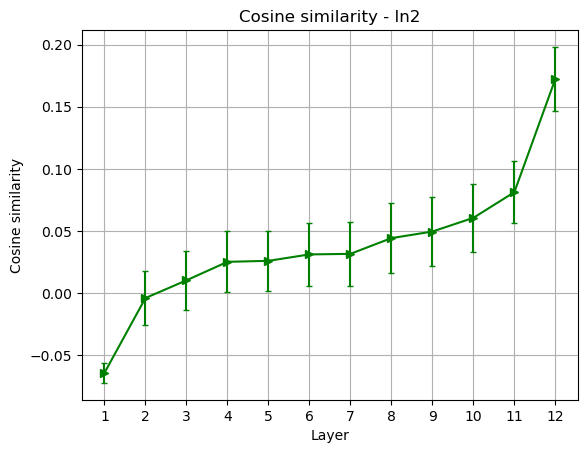

In [50]:
plot_avg_cos_sim(cos_sim_ln2[0],cos_sim_ln2[1],'green','Cosine similarity - ln2', '>')

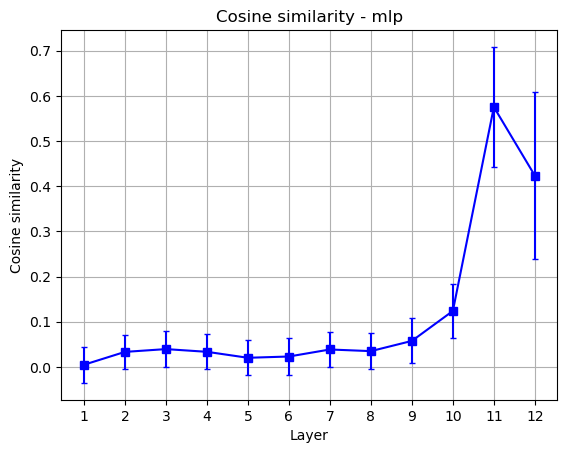

In [51]:
plot_avg_cos_sim(cos_sim_mlp_proj[0], cos_sim_mlp_proj[1], 'blue', 'Cosine similarity - mlp', 's')

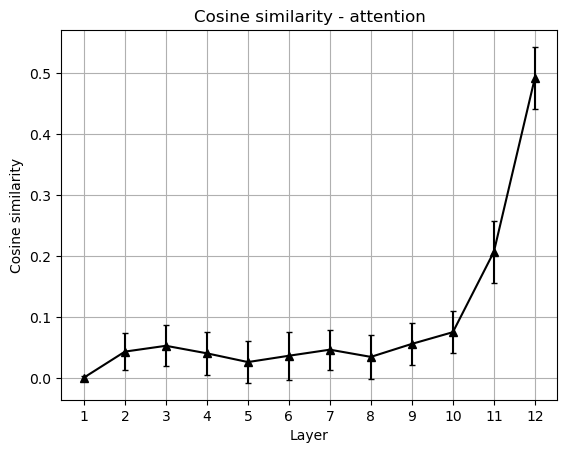

In [52]:
plot_avg_cos_sim(cos_sim_attention[0],cos_sim_attention[1],'black','Cosine similarity - attention', '^')